In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

## Data Loading

In [3]:
data = pd.read_csv("kc_house_data.csv")

In [4]:
labels = data['price']
conv_dates = [1 if values == 2014 else 0 for values in data.date ]
data['date'] = conv_dates
train1 = data.drop(['id', 'price'],axis=1)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(train1, labels, test_size=0.10, random_state=2)

## Models 
inspired by : 
https://github.com/Shreyas3108/house-price-prediction/blob/master/housesales.ipynb

In [6]:
clf = GradientBoostingRegressor(n_estimators=400, max_depth=5, min_samples_split=2,
          learning_rate=0.1, loss='ls')

In [7]:
clf.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=400, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [8]:
clf.score(x_test, y_test)

0.9203097226257193

In [9]:
clf = RandomForestRegressor(n_estimators=400, max_depth=5, min_samples_split=2)
clf.fit(x_train, y_train)
clf.score(x_test,y_test)

0.7931029875458855

## lets keep few interesting features :

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 <a list of 19 Text xticklabel objects>)

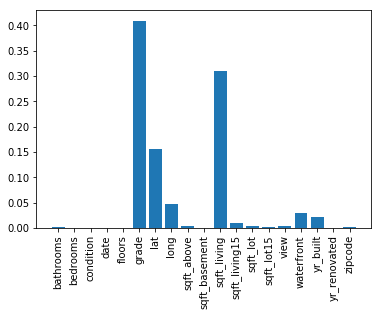

In [10]:
plt.bar(x_test.columns,clf.feature_importances_)
plt.xticks(rotation=90)

In [11]:
col_imp = ["grade", "lat", "long", "sqft_living", "waterfront", "yr_built"]

In [12]:
clf = GradientBoostingRegressor(n_estimators = 400, max_depth = 5, min_samples_split = 2)
clf.fit(x_train[col_imp], y_train)
clf.score(x_test[col_imp],y_test)

0.8909980918969321

Keeping only few important columns decrease a bit the score

### Function who will be used in the flask server

In [13]:
def predict(dict_values,col_imp=col_imp, clf=clf):
    x = np.array([float(dict_values[col]) for col in col_imp])
    x = x.reshape(1,-1)
    y_pred = clf.predict(x)[0]
    return y_pred

In [14]:
x_test[col_imp].iloc[42].T.to_json()

'{"grade":10.0,"lat":47.5396,"long":-122.073,"sqft_living":4490.0,"waterfront":0.0,"yr_built":2006.0}'

In [15]:
x_test_json = {"grade":10.0,"lat":47.6307,
"long":-122.088,"sqft_living":2170.0,"waterfront":1.0,"yr_built":1979.0}

In [16]:
predict(x_test_json)

1447155.5590082603

I save an example just to try the example 

In [17]:
x_test[col_imp].iloc[42].T.to_json("../to_predict_json.json")

## Train function

 We have for objective train and test few pipeline trought the api.
 

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler, QuantileTransformer

In [34]:
Pipelines = [
    ("gbr", GradientBoostingRegressor(n_estimators=400, max_depth=5, min_samples_split=2, learning_rate=0.1, loss='ls')),
    ("st_lasso", Pipeline([('st', StandardScaler()), ('Lasso', Lasso())])),
    ("st_sfm_svr", Pipeline([('st', QuantileTransformer()), ('SFM', SelectFromModel(Lasso())),
                             ('SVR', SVR(C =10000, epsilon=10000))])),
    ("sfm_gbr", Pipeline([('SFM', SelectFromModel(RandomForestRegressor(n_estimators=400, max_depth=5,
                                                                        min_samples_split=2),threshold=0,max_features=7)), 
              ('GBR', GradientBoostingRegressor(n_estimators=400, max_depth=5,
                                                min_samples_split=2, learning_rate=0.1, loss='ls'))]))
]

In [35]:
def train(path_csv_train, target=None, input_columns=None, Pipelines=Pipelines):
    assert isinstance(target,str), "target is not defined"
    data = pd.read_csv(path_csv_train)
    data = data.select_dtypes(include=[np.number])
    assert target in data.columns, "target should be in the columns list ; %s"%(data.columns,)
    if input_columns is None :
        input_columns = list(data.columns)
        input_columns.remove(target)
    
    X = data.drop(target,axis=1)
    y = data[target]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=2)
    list_test_score = []
    for pipeline_name, pipeline in Pipelines :
        pipeline.fit(x_train, y_train)
        test_score = pipeline.score(x_test, y_test)
        print("%s test score : %s"%(pipeline_name, test_score))
        list_test_score.append(test_score)
    best_test_score = np.max(list_test_score)
    best_pipeline = Pipelines[np.argmax(list_test_score)][1]
    return best_test_score, best_pipeline, input_columns

In [36]:
best_score, best_pipeline, input_columns = train("kc_house_data.csv", target='price')

gbr test score : 0.9185507603688683


/home/seb/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/seb/anaconda3/lib/python3.5/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/home/seb/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/seb/anaconda3/lib/python3.5/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


st_lasso test score : 0.7321475700195835


/home/seb/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


st_sfm_svr test score : 0.04132052015192089
sfm_gbr test score : 0.9041532606067071


In [37]:
input_columns

['id',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [38]:
best_score

0.9185507603688683

In [40]:
best_pipeline.predict(data.drop(['price','date'],axis=1))

array([216676.77030151, 503161.77499555, 223374.40757467, ...,
       352167.3542465 , 451737.90650443, 340798.67737619])

In [53]:
data.drop(['price','date'],axis=1).shape

(21613, 19)

In [52]:
len(input_columns)

19

In [55]:
def predict(dict_values, input_columns=None, model=None):
    assert not (input_columns is None), "input_columns is not defined"
    assert not (model is None), "model is not defined"
    x = np.array([float(dict_values[col]) for col in input_columns])
    x = x.reshape(1,-1)
    y_pred = model.predict(x)[0]
    return y_pred

In [56]:
data[input_columns].iloc[42].T.to_json()

'{"id":7203220400.0,"bedrooms":5.0,"bathrooms":2.75,"sqft_living":3595.0,"sqft_lot":5639.0,"floors":2.0,"waterfront":0.0,"view":0.0,"condition":3.0,"grade":9.0,"sqft_above":3595.0,"sqft_basement":0.0,"yr_built":2014.0,"yr_renovated":0.0,"zipcode":98053.0,"lat":47.6848,"long":-122.016,"sqft_living15":3625.0,"sqft_lot15":5639.0}'

In [65]:
data[input_columns].iloc[42].T.to_json("../to_predict_json.json")

In [57]:
json_input={"id":7203220400.0,"bedrooms":5.0,"bathrooms":2.75,"sqft_living":3595.0,
            "sqft_lot":5639.0,"floors":2.0,"waterfront":0.0,"view":0.0,"condition":3.0,
            "grade":9.0,"sqft_above":3595.0,"sqft_basement":0.0,"yr_built":2014.0,
            "yr_renovated":0.0,"zipcode":98053.0,"lat":47.6848,"long":-122.016,
            "sqft_living15":3625.0,"sqft_lot15":5639.0}


In [58]:
predict(json_input, input_columns, model=best_pipeline)

893077.4271269966

In [59]:
import joblib

In [61]:
joblib.dump(best_pipeline, "best_pipeline")

['best_pipeline']

In [62]:
ls

best_pipeline         kc_house_data.csv  __pycache__/  start_flask.sh
house_princing.ipynb  prediction.py      server.py


In [63]:
from flask import session

In [64]:
session['my_var'] = 'my_value'

RuntimeError: Working outside of request context.

This typically means that you attempted to use functionality that needed
an active HTTP request.  Consult the documentation on testing for
information about how to avoid this problem.